# Trait Predictor Model

Project objective was to develop the machine learning application that would predict the personality trait of a person as Introvert/Extrovert/Ambivert based on 91 personality questions. Our ML algorithm is trained based on survey with the same set of personality questions.

## Initial Setup

In [1]:
# Dependencies
import pandas as pd
from pathlib import Path
import numpy as np

from config import driver, username, password, host, port, database
from sqlalchemy import create_engine

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pickle

In [2]:
# AWS RDS Connection setup

connection_string = f"{driver}://{username}:{password}@{host}:{port}/{database}"
engine = create_engine(connection_string)
connection = engine.connect()

In [3]:
# Read Questions list from AWS RDS

QuestionsListDF = pd.read_sql_table('questionslist', connection)
QuestionsListDF.head()

,QuestionNum,Question
0,Q1,"""I would never audition to be on a game show."""
1,Q2,"""I am not much of a flirt."""
2,Q3,"""I have to psych myself up before I am brave e..."
3,Q4,"""I would hate living with room mates."""
4,Q5,"""I mostly listen to people in conversations."""


In [4]:
# pd.options.display.max_columns = 300
# pd.options.display.max_columns = 100
pd.options.display.max_columns = 20

In [5]:
# # local csv file read

# QuestionnaireDF = pd.read_csv(Path('../resources/data.csv'), delimiter='\t')
# QuestionnaireDF.rename(columns ={'country':'COUNTRY', 
#                                  'dateload':'DATELOAD',
#                                  'introelapse':'INTROELAPSE',
#                                  'testelapse':'TESTELAPSE',
#                                  'surveyelapse':'SURVEYELAPSE',
#                                  'gender':'GENDER',
#                                  'engnat':'ENGNAT',
#                                  'age':'AGE',
#                                  'IE':'INTROVERT_EXTROVERT'}, inplace=True)
# QuestionnaireDF

In [6]:
# Read Questionnaire Survey Dataset from AWS RDS

QuestionnaireDF = pd.read_sql_table('questionnaire', connection)
QuestionnaireDF.head()

,row_id,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,...,Q91E,COUNTRY,DATELOAD,INTROELAPSE,TESTELAPSE,SURVEYELAPSE,GENDER,ENGNAT,AGE,INTROVERT_EXTROVERT
0,1,5,51,7107,3,91,2522,1,56,6180,...,4609,US,2019-02-20 17:35:52,1,461,16,2,1,23,3
1,2,5,39,6354,5,13,3092,1,12,5243,...,10409,AU,2019-02-20 17:46:32,21,467,15,1,2,25,2
2,3,3,17,5397,4,35,2747,5,40,5262,...,2691,BR,2019-02-20 18:10:24,56,306,17,1,2,19,1
3,4,5,41,3055,2,14,3348,1,13,5141,...,3697,CZ,2019-02-20 18:16:21,2,287,14,1,1,23,1
4,5,1,76,2542,2,54,1878,1,15,5637,...,1662,CA,2019-02-20 18:21:49,2,325,12,1,1,18,2


## Preprocessing: Data cleanup

In [7]:
# filtering the rows that are not contributing to Classification values "Introvert/Extrovert/Ambivert" 

QuestionnaireDF = QuestionnaireDF.loc[QuestionnaireDF['INTROVERT_EXTROVERT'] != 0]
QuestionnaireDF

,row_id,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,...,Q91E,COUNTRY,DATELOAD,INTROELAPSE,TESTELAPSE,SURVEYELAPSE,GENDER,ENGNAT,AGE,INTROVERT_EXTROVERT
0,1,5,51,7107,3,91,2522,1,56,6180,...,4609,US,2019-02-20 17:35:52,1,461,16,2,1,23,3
1,2,5,39,6354,5,13,3092,1,12,5243,...,10409,AU,2019-02-20 17:46:32,21,467,15,1,2,25,2
2,3,3,17,5397,4,35,2747,5,40,5262,...,2691,BR,2019-02-20 18:10:24,56,306,17,1,2,19,1
3,4,5,41,3055,2,14,3348,1,13,5141,...,3697,CZ,2019-02-20 18:16:21,2,287,14,1,1,23,1
4,5,1,76,2542,2,54,1878,1,15,5637,...,1662,CA,2019-02-20 18:21:49,2,325,12,1,1,18,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,7184,1,46,1328,4,82,3214,4,43,3360,...,3495,US,2019-08-19 12:54:22,8,299,14,2,1,53,1
7184,7185,2,5,8786,5,24,2233,5,10,10387,...,6088,CA,2019-08-19 13:10:30,25,498,20,1,1,20,1
7185,7186,3,29,6618,5,44,2393,4,58,5768,...,3425,BY,2019-08-19 13:29:47,3,326,17,2,2,28,1
7186,7187,4,15,8321,2,18,6179,5,60,5037,...,17416,CA,2019-08-19 15:19:35,3,414,23,2,1,19,1


In [8]:
# Selecting only features that are considered to be important for training the model

QuestionnaireDF = QuestionnaireDF.drop(columns=['row_id','COUNTRY', 'DATELOAD', 'INTROELAPSE', 'TESTELAPSE', 'SURVEYELAPSE'])
QuestionnaireDF.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Q90A,Q90I,Q90E,Q91A,Q91I,Q91E,GENDER,ENGNAT,AGE,INTROVERT_EXTROVERT
0,5,51,7107,3,91,2522,1,56,6180,2,...,3,40,4648,3,35,4609,2,1,23,3
1,5,39,6354,5,13,3092,1,12,5243,5,...,4,28,3884,3,1,10409,1,2,25,2
2,3,17,5397,4,35,2747,5,40,5262,3,...,1,87,1759,1,19,2691,1,2,19,1
3,5,41,3055,2,14,3348,1,13,5141,1,...,3,15,2345,3,23,3697,1,1,23,1
4,1,76,2542,2,54,1878,1,15,5637,1,...,5,86,6413,5,69,1662,1,1,18,2


In [9]:
# Validating the data in the selected features

QuestionnaireDF['AGE'].sort_values().unique()

array([     14,      15,      16,      17,      18,      19,      20,
            21,      22,      23,      24,      25,      26,      27,
            28,      29,      30,      31,      32,      33,      34,
            35,      36,      37,      38,      39,      40,      41,
            42,      43,      44,      45,      46,      47,      48,
            49,      50,      51,      52,      53,      54,      55,
            56,      57,      58,      59,      60,      61,      62,
            63,      64,      65,      66,      67,      68,      69,
            70,      71,      72,      73,      75,      77,      78,
            79,      81,      90,     255,    1979,    1983,    1990,
          1991,    1996,    1999,    2003, 8675309], dtype=int64)

In [10]:
# Define variables for cleaning age feature. Drop rows with age above max_age

max_age = 100
# Age: Clean up invalid rows where age is above max_age
age_range = (QuestionnaireDF['AGE'] < max_age)
QuestionnaireDF = QuestionnaireDF.loc[age_range]

In [11]:
# DF values after the age clean up

QuestionnaireDF['AGE'].sort_values().unique()

array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
       65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 77, 78, 79, 81, 90],
      dtype=int64)

In [12]:
#  Selecting only the response columns from the dataframe. Ignoring the columns with Question sequence and response time.

ColumnsList = QuestionnaireDF.columns.to_list()

surveyResponseColumnsList = []
for column in ColumnsList:
    if (column[0] == 'Q' and column[-1] == 'A'):
        surveyResponseColumnsList.append(column)

In [13]:
# elapsedTimeColumnsList = []
# for column in ColumnsList:
#     if (column[0] == 'Q' and column[-1] == 'E'):
#         elapsedTimeColumnsList.append(column)
        
# elapsedTimeColumnsList   

In [14]:
# elapsedTimeColumnsDF = QuestionnaireDF[['Q1E', 'Q2E', 'Q3E', 'Q4E', 'Q5E']]
# elapsedTimeColumnsDF = QuestionnaireDF[elapsedTimeColumnsList]
# elapsedTimeColumnsDF.head()

In [15]:
# 1 Minute = 60 Seconds = 60,000 Milliseconds
# Identify all rows that have atleast one response time more than 1 minute

# elapsedTimeColumnsDF['Q1E'].loc[lambda x : x > 60000]
# outliersDF = elapsedTimeColumnsDF[elapsedTimeColumnsDF.gt(60000).any(axis=1)]
# outliersDF

In [16]:
# outliersinSecondsDF=outliersDF/1000
# outliersinSecondsDF

In [17]:
#Final Cleansed DF for Machine Learning. Since the data is already numeric, there is no need to convert the categorical data to numeric.

CleansedDF = QuestionnaireDF[surveyResponseColumnsList].copy()

#Initially we thought of using Gender, English Language and Age for Predicting the personality. But later we changed our thoughts.
# CleansedDF['GENDER'] = QuestionnaireDF['GENDER']
# CleansedDF['ENGNAT'] = QuestionnaireDF['ENGNAT']
# CleansedDF['AGE'] = QuestionnaireDF['AGE']

CleansedDF['INTROVERT_EXTROVERT'] = QuestionnaireDF['INTROVERT_EXTROVERT']

CleansedDF

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,Q83A,Q84A,Q85A,Q86A,Q87A,Q88A,Q89A,Q90A,Q91A,INTROVERT_EXTROVERT
0,5,3,1,2,3,2,3,3,4,5,...,3,2,1,4,2,5,4,3,3,3
1,5,5,1,5,2,2,5,2,1,3,...,2,2,2,1,3,4,4,4,3,2
2,3,4,5,3,4,5,5,5,5,5,...,5,5,5,4,5,3,2,1,1,1
3,5,2,1,1,5,5,5,4,4,2,...,5,5,5,3,5,4,4,3,3,1
4,1,2,1,1,3,3,5,1,3,4,...,3,1,1,3,1,2,5,5,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,1,4,4,5,5,4,4,4,4,4,...,3,5,3,4,3,4,2,5,4,1
7184,2,5,5,5,4,4,5,5,4,3,...,3,5,4,5,4,3,1,3,2,1
7185,3,5,4,5,5,5,4,5,5,5,...,5,5,5,4,5,3,1,1,1,1
7186,4,2,5,1,5,1,5,4,5,1,...,4,5,1,4,1,1,4,5,2,1


## Machine learning 

In [18]:
CleansedDF.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,Q83A,Q84A,Q85A,Q86A,Q87A,Q88A,Q89A,Q90A,Q91A,INTROVERT_EXTROVERT
0,5,3,1,2,3,2,3,3,4,5,...,3,2,1,4,2,5,4,3,3,3
1,5,5,1,5,2,2,5,2,1,3,...,2,2,2,1,3,4,4,4,3,2
2,3,4,5,3,4,5,5,5,5,5,...,5,5,5,4,5,3,2,1,1,1
3,5,2,1,1,5,5,5,4,4,2,...,5,5,5,3,5,4,4,3,3,1
4,1,2,1,1,3,3,5,1,3,4,...,3,1,1,3,1,2,5,5,5,2


In [19]:
# Separate features data for training the model

X = CleansedDF.drop(columns=['INTROVERT_EXTROVERT'])
X

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,Q82A,Q83A,Q84A,Q85A,Q86A,Q87A,Q88A,Q89A,Q90A,Q91A
0,5,3,1,2,3,2,3,3,4,5,...,1,3,2,1,4,2,5,4,3,3
1,5,5,1,5,2,2,5,2,1,3,...,1,2,2,2,1,3,4,4,4,3
2,3,4,5,3,4,5,5,5,5,5,...,5,5,5,5,4,5,3,2,1,1
3,5,2,1,1,5,5,5,4,4,2,...,5,5,5,5,3,5,4,4,3,3
4,1,2,1,1,3,3,5,1,3,4,...,2,3,1,1,3,1,2,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,1,4,4,5,5,4,4,4,4,4,...,4,3,5,3,4,3,4,2,5,4
7184,2,5,5,5,4,4,5,5,4,3,...,3,3,5,4,5,4,3,1,3,2
7185,3,5,4,5,5,5,4,5,5,5,...,5,5,5,5,4,5,3,1,1,1
7186,4,2,5,1,5,1,5,4,5,1,...,5,4,5,1,4,1,1,4,5,2


In [20]:
# Separate classification label for training the model

y = CleansedDF['INTROVERT_EXTROVERT']
y

0       3
1       2
2       1
3       1
4       2
       ..
7183    1
7184    1
7185    1
7186    1
7187    1
Name: INTROVERT_EXTROVERT, Length: 7153, dtype: int64

In [21]:
# Split data into training and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

In [22]:
# Train and Test data dimensions.

print(f"X_Train Shape: {X_train.shape} \nX_Train Columns: {X_train.columns}")
print(f"X_Test Shape: {X_test.shape} \nX_Test Columns: {X_test.columns}")

X_Train Shape: (4792, 91) 
X_Train Columns: Index(['Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A', 'Q7A', 'Q8A', 'Q9A', 'Q10A',
       'Q11A', 'Q12A', 'Q13A', 'Q14A', 'Q15A', 'Q16A', 'Q17A', 'Q18A', 'Q19A',
       'Q20A', 'Q21A', 'Q22A', 'Q23A', 'Q24A', 'Q25A', 'Q26A', 'Q27A', 'Q28A',
       'Q29A', 'Q30A', 'Q31A', 'Q32A', 'Q33A', 'Q34A', 'Q35A', 'Q36A', 'Q37A',
       'Q38A', 'Q39A', 'Q40A', 'Q41A', 'Q42A', 'Q43A', 'Q44A', 'Q45A', 'Q46A',
       'Q47A', 'Q48A', 'Q49A', 'Q50A', 'Q51A', 'Q52A', 'Q53A', 'Q54A', 'Q55A',
       'Q56A', 'Q57A', 'Q58A', 'Q59A', 'Q60A', 'Q61A', 'Q62A', 'Q63A', 'Q64A',
       'Q65A', 'Q66A', 'Q67A', 'Q68A', 'Q69A', 'Q70A', 'Q71A', 'Q72A', 'Q73A',
       'Q74A', 'Q75A', 'Q76A', 'Q77A', 'Q78A', 'Q79A', 'Q80A', 'Q81A', 'Q82A',
       'Q83A', 'Q84A', 'Q85A', 'Q86A', 'Q87A', 'Q88A', 'Q89A', 'Q90A', 'Q91A'],
      dtype='object')
X_Test Shape: (2361, 91) 
X_Test Columns: Index(['Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A', 'Q7A', 'Q8A', 'Q9A', 'Q10A',
       'Q11A', 'Q12A', '

## Unsupervised Learning - K-Means Clustering

### Elbow Curve based on K-Means Algorithm shows there would be 3 clusters in the dataset. This can be understood as three classes - Introvert, Extrovert and Ambivert

In [23]:
# Finding the best value for _k_ using the Elbow Curve
from sklearn.cluster import KMeans

inertia = []
k = list(range(1, 11))

# Looking for the best k
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    inertia.append(km.inertia_)

# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

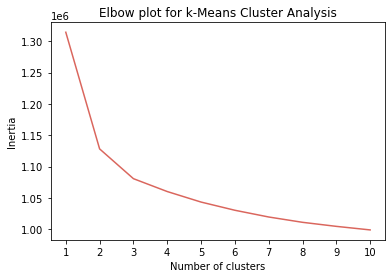

In [24]:
# Elbow curve to identify the best number of clusters

plt.plot(df_elbow['k'], df_elbow['inertia'], color='#DA665D')
plt.xticks(k)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow plot for k-Means Cluster Analysis')
plt.savefig('../Images/Elbow-plot-k-Means-Cluster.png')
plt.show()

## Supervised Learning - Random Forest Classifier

In [25]:
# Train a Random Forest Classifier model and print the model score

rf_uns_classifier = RandomForestClassifier(random_state=1, n_estimators=400).fit(X_train, y_train)

print("----------------------------------------------")
print("Random Forest Classifier - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {rf_uns_classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {rf_uns_classifier.score(X_test, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Random Forest Classifier - Unscaled Data
----------------------------------------------
Training Data Score: 1.0
Testing Data Score: 0.7246929267259635
----------------------------------------------


In [26]:
# save the model to disk using pickle

filename = '../saved_models/IE_Predictor_model.sav'
pickle.dump(rf_uns_classifier, open(filename, 'wb'))

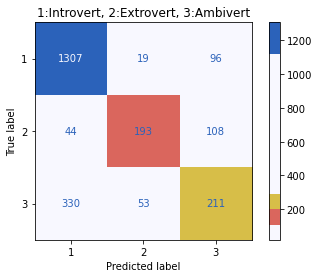

In [70]:
# Calculate metrics and plot the matrix

y_pred = rf_uns_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=rf_uns_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_uns_classifier.classes_)

# ml_cmap = ListedColormap(['#DA665D', '#D7BE48', '#2B62BA'])

# To maintain uniformity, setting up tableau colors to each bin so we have different colors for True predictions.
# True Introverts, True Extroverts, True Ambiverts
ml_cmap = ListedColormap(['#F8F8FF', '#DA665D', '#D7BE48', '#F8F8FF', '#F8F8FF', '#F8F8FF', '#F8F8FF', '#F8F8FF', '#F8F8FF', '#F8F8FF', '#F8F8FF', '#F8F8FF', '#2B62BA', '#2B62BA'])

disp.plot(cmap = ml_cmap)

plt.title('1:Introvert, 2:Extrovert, 3:Ambivert')
plt.savefig("../images/ConfMatrix-Introvert-Extrovert-Ambivert.png")
plt.show()

In [28]:
# True Introverts, True Entroverts, True Ambiverts
# accuracy = (tp + tn) / (tp + fp + tn + fn) 

ti, fi1, fi2, fe1, te, fe2, fa1, fa2, ta = confusion_matrix(y_test, y_pred).ravel()
accuracy = (ti + te +ta) / (ti + fi1 + fi2 + fe1 + te + fe2 + fa1 + fa2 + ta) 
print(f'Accuracy: {accuracy:.5f}')

Accuracy: 0.72469


Since we are trying to predict more than 2 classes, the metrics cannot be calculated as average=Binary. All the 4 metrics Accuracy, Precision, Recall and F1 Score seem to good when they are calculated using "MICRO", "MACRO", "WEIGHTED", MICRO seems to be provide the higher values.

In [29]:
# Calculate metrics for the Random Forest Classifier model
print('---------------------------------------------------------')
print('\nMetrics of Random Forest Classifier Model: Average=micro')
print('---------------------------------------------------------')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, y_pred,)))
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred, average='micro')))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred, average='micro')))
print('---------------------------------------------------------')
print('Classification Report')
print('---------------------------------------------------------')
print(classification_report(y_test, y_pred))

---------------------------------------------------------

Metrics of Random Forest Classifier Model: Average=micro
---------------------------------------------------------
Accuracy = 0.72469
Precision = 0.72469
Recall = 0.72469
F1 score = 0.72469
---------------------------------------------------------
Classification Report
---------------------------------------------------------
              precision    recall  f1-score   support

           1       0.78      0.92      0.84      1422
           2       0.73      0.56      0.63       345
           3       0.51      0.36      0.42       594

    accuracy                           0.72      2361
   macro avg       0.67      0.61      0.63      2361
weighted avg       0.70      0.72      0.71      2361



In [30]:
print('---------------------------------------------------------')
print('Metrics of Random Forest Classifier Model: Average=macro')
print('---------------------------------------------------------')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, y_pred,)))
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred, average='macro')))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred, average='macro')))
print('---------------------------------------------------------')
print('Classification Report')
print('---------------------------------------------------------')
print(classification_report(y_test, y_pred))

---------------------------------------------------------
Metrics of Random Forest Classifier Model: Average=macro
---------------------------------------------------------
Accuracy = 0.72469
Precision = 0.67142
Recall = 0.61126
F1 score = 0.63114
---------------------------------------------------------
Classification Report
---------------------------------------------------------
              precision    recall  f1-score   support

           1       0.78      0.92      0.84      1422
           2       0.73      0.56      0.63       345
           3       0.51      0.36      0.42       594

    accuracy                           0.72      2361
   macro avg       0.67      0.61      0.63      2361
weighted avg       0.70      0.72      0.71      2361



In [31]:
print('-----------------------------------------------------------')
print('Metrics of Random Forest Classifier Model: Average=weighted')
print('-----------------------------------------------------------')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, y_pred,)))
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred, average='weighted')))
print('-----------------------------------------------------------')
print('Classification Report')
print('-----------------------------------------------------------')
print(classification_report(y_test, y_pred))

-----------------------------------------------------------
Metrics of Random Forest Classifier Model: Average=weighted
-----------------------------------------------------------
Accuracy = 0.72469
Precision = 0.70263
Recall = 0.72469
F1 score = 0.70506
-----------------------------------------------------------
Classification Report
-----------------------------------------------------------
              precision    recall  f1-score   support

           1       0.78      0.92      0.84      1422
           2       0.73      0.56      0.63       345
           3       0.51      0.36      0.42       594

    accuracy                           0.72      2361
   macro avg       0.67      0.61      0.63      2361
weighted avg       0.70      0.72      0.71      2361



## Scale the data

In [32]:
# Scale the data

# adding import dependencies here again for my reference.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest on Scaled data

In [33]:
# Train a Random Forest Classifier model on the scaled data and print the model score
from sklearn.ensemble import RandomForestClassifier

rf_s_classifier = RandomForestClassifier(random_state=1, n_estimators=400).fit(X_train_scaled, y_train)
print("----------------------------------------------")
print("Random Forest Classifier - Scaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {rf_s_classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {rf_s_classifier.score(X_test_scaled, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Random Forest Classifier - Scaled Data
----------------------------------------------
Training Data Score: 1.0
Testing Data Score: 0.7246929267259635
----------------------------------------------


## Logistic Regression

Logistic Regression has better performance over Random Forest classifier. Scaled data has little better accuracy over the Unscaled data.

In [36]:
# Train the Logistic Regression model on the unscaled data and print the model score

# adding import dependencies here again for my reference.
from sklearn.linear_model import LogisticRegression

lr_uns_classifier = LogisticRegression(random_state=1)
lr_uns_classifier.fit(X_train, y_train)

print("----------------------------------------------")
print("Logistic Regression - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {lr_uns_classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {lr_uns_classifier.score(X_test, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Logistic Regression - Unscaled Data
----------------------------------------------
Training Data Score: 0.7765025041736227
Testing Data Score: 0.7259635747564591
----------------------------------------------


C:\Users\kesam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
# Train the Logistic Regression model on the scaled data and print the model score

# adding import dependencies here again for my reference.
from sklearn.linear_model import LogisticRegression

lr_s_classifier = LogisticRegression(random_state=1)
lr_s_classifier.fit(X_train_scaled, y_train)

print("----------------------------------------------")
print("Logistic Regression - Scaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {lr_s_classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {lr_s_classifier.score(X_test_scaled, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Logistic Regression - Scaled Data
----------------------------------------------
Training Data Score: 0.7773372287145242
Testing Data Score: 0.7285048708174502
----------------------------------------------


## Multiple Linear Regression

Definitely Linear Regression has very low accracy and would definitely not be considered for any predictions in this app.

In [38]:
# Train the Linear Regression model on the unscaled data and print the model score
# adding import dependencies here again for my reference.

from sklearn.linear_model import LinearRegression
lnr_uns_classifier = LinearRegression()

# Fitting our model with all our features in X
lnr_uns_classifier.fit(X_train, y_train)

print("----------------------------------------------")
print("Linear Regression - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {lnr_uns_classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {lnr_uns_classifier.score(X_test, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Linear Regression - Unscaled Data
----------------------------------------------
Training Data Score: 0.29771414306965005
Testing Data Score: 0.23095512862618128
----------------------------------------------


In [39]:
# Train the Linear Regression model on the scaled data and print the model score

from sklearn.linear_model import LinearRegression
lnr_s_classifier = LinearRegression()

# Fitting our model with all our features in X
lnr_s_classifier.fit(X_train_scaled, y_train)

print("----------------------------------------------")
print("Linear Regression - Scaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {lnr_uns_classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {lnr_uns_classifier.score(X_test_scaled, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Linear Regression - Scaled Data
----------------------------------------------
Training Data Score: -0.18858285304377498
Testing Data Score: -0.2028256166826352
----------------------------------------------


## Supervised Learning - Optimization attempts

To optimize the performance of our machine learning model, we tried different Classifier algorithms with various hyperparameters. 

Optimization attempts were made using the Logistic Regression, Random Forest, Support Vector Machine, Bagging, AdaBoost and Voting classifiers. 
More classifiers we tried through Voting Classifier, the accuracy of the predictions improved to 73% .

### Random Forest

Tried multiple attemps with different set of hyperparameters to see if the accuracy of Random Forest classifier can be improved.

In [41]:
# Train a Random Forest Classifier model and print the model score

rf_uns_classifier_oa = RandomForestClassifier(random_state=1, n_estimators=1000, max_features=None, n_jobs=-1, max_depth=None, bootstrap=True).fit(X_train, y_train)
# rf_uns_classifier_oa = RandomForestClassifier(random_state=1, n_estimators=1000, max_features="sqrt", n_jobs=-1, max_depth=None, min_samples_split=2, bootstrap=False).fit(X_train, y_train)
# rf_uns_classifier_oa = RandomForestClassifier(random_state=1, n_estimators=50, max_leaf_nodes=16, n_jobs=-1).fit(X_train, y_train)
# rf_uns_classifier_oa = RandomForestClassifier(random_state=1, n_estimators=100, max_features=None, n_jobs=-1, max_depth=2, bootstrap=True).fit(X_train, y_train)

print("----------------------------------------------")
print("Random Forest Classifier - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {rf_uns_classifier_oa.score(X_train, y_train)}")
print(f"Testing Data Score: {rf_uns_classifier_oa.score(X_test, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Random Forest Classifier - Unscaled Data
----------------------------------------------
Training Data Score: 1.0
Testing Data Score: 0.7238458280389666
----------------------------------------------


### Bagging

Bagging allows training instances to be sampled several times for the same predictor. When sampling is performed with replacement, this method is called bagging. When sampling is performed without replacement, it is called pasting.

In [53]:
# Bagging --> bootstrap=True: so the sample would be replaced back.

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
                    DecisionTreeClassifier(splitter="random"),
                    n_estimators = 400, max_samples=1.0, bootstrap=True, n_jobs = -1
                        )

bag_clf.fit(X_train, y_train)

print("----------------------------------------------")
print("Bagging Classifier - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {bag_clf.score(X_train, y_train)}")
print(f"Testing Data Score: {bag_clf.score(X_test, y_test)}")
print("----------------------------------------------")


# Commented below code as Unscaled data provided better accuracy
# bag_clf.fit(X_train_scaled, y_train)

# print("----------------------------------------------")
# print("Bagging Classifier - Scaled Data")
# print("----------------------------------------------")
# print(f"Training Data Score: {bag_clf.score(X_train_scaled, y_train)}")
# print(f"Testing Data Score: {bag_clf.score(X_test_scaled, y_test)}")
# print("----------------------------------------------")

----------------------------------------------
Bagging Classifier - Unscaled Data
----------------------------------------------
Training Data Score: 1.0
Testing Data Score: 0.7285048708174502
----------------------------------------------


In [45]:
# Pasting --> bootstrap=False: so the sample would NOT be replaced.

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf_pasting = BaggingClassifier(
                    DecisionTreeClassifier(splitter="random"),
                    n_estimators = 400, max_samples=1.0, bootstrap=False, n_jobs = -1
                        )

bag_clf_pasting.fit(X_train, y_train)

print("----------------------------------------------")
print("Bagging Classifier - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {bag_clf.score(X_train, y_train)}")
print(f"Testing Data Score: {bag_clf.score(X_test, y_test)}")
print("----------------------------------------------")

# Commented below code as Unscaled data provided better accuracy
# bag_clf_pasting.fit(X_train_scaled, y_train)

# print("----------------------------------------------")
# print("Bagging Classifier - Scaled Data")
# print("----------------------------------------------")
# print(f"Training Data Score: {bag_clf.score(X_train_scaled, y_train)}")
# print(f"Testing Data Score: {bag_clf.score(X_test_scaled, y_test)}")
# print("----------------------------------------------")

----------------------------------------------
Bagging Classifier - Unscaled Data
----------------------------------------------
Training Data Score: 0.6212437395659433
Testing Data Score: 0.602287166454892
----------------------------------------------


### Boosting

In [56]:
# AdaBoost - When training an AdaBoost classifier, the algorithm first trains a base classifier (Here "Decision Tree") and uses it to make predictions on the training set.
#  The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier using the updated weights and 
#  again makes predictions on the training set, updates the instance weights and so on.

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators = 400, algorithm='SAMME.R', learning_rate=0.5
                            )

ada_clf.fit(X_train, y_train)

print("----------------------------------------------")
print("AdaBoost Classifier - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {ada_clf.score(X_train, y_train)}")
print(f"Testing Data Score: {ada_clf.score(X_test, y_test)}")
print("----------------------------------------------")

ada_clf.fit(X_train_scaled, y_train)

print("----------------------------------------------")
print("AdaBoost Classifier - Scaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {ada_clf.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {ada_clf.score(X_test_scaled, y_test)}")
print("----------------------------------------------")

----------------------------------------------
AdaBoost Classifier - Unscaled Data
----------------------------------------------
Training Data Score: 0.7627295492487479
Testing Data Score: 0.7213045319779754
----------------------------------------------
----------------------------------------------
AdaBoost Classifier - Scaled Data
----------------------------------------------
Training Data Score: 0.7627295492487479
Testing Data Score: 0.7213045319779754
----------------------------------------------


### Voting Classifier

We have trained a few classifiers, each one mostly achieving about 72% accuracy. Utilized the voting classifier to see better predictions among them and was able to arrive at 73% accuracy.

By definition of Voting classifier, it provides a way to create a better classifier by aggregating the predictions of each classifier and predict the class that gets the most votes. This majority vote classifier is called a hard voting classifier

If all classifiers are able to estimate class probabilities, then we can predict the class with the highest class probability, averaged over all the individual classifiers. This is considered to be soft voting.

Clearly, we can see that Voting classifier slightly outperforms all the individual classifiers.

In [48]:
log_clf=LogisticRegression(random_state=1)
rnd_clf=RandomForestClassifier(random_state=1, n_estimators=400)
svm_clf=SVC(random_state=1, probability=True)

In [51]:
#Hard Voting

voting_clf=VotingClassifier(
                estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('adb', ada_clf), ('bc', bag_clf)],
                voting='hard')
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, ada_clf, bag_clf, voting_clf):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

C:\Users\kesam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kesam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression 0.7259635747564591
RandomForestClassifier 0.7246929267259635
SVC 0.7221516306649725
AdaBoostClassifier 0.7289284201609487
BaggingClassifier 0.7259635747564591


C:\Users\kesam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier 0.7297755188479458


In [57]:
#soft Voting

voting_clf=VotingClassifier(
                estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('adb', ada_clf), ('bc', bag_clf)],
                voting='soft')
voting_clf.fit(X_train_scaled, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, ada_clf, bag_clf, voting_clf):
    clf.fit(X_train_scaled,y_train)
    y_pred=clf.predict(X_test_scaled)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7285048708174502
RandomForestClassifier 0.7246929267259635
SVC 0.7251164760694621
AdaBoostClassifier 0.7213045319779754
BaggingClassifier 0.7213045319779754
VotingClassifier 0.7293519695044473


In [62]:
#soft Voting

voting_clf=VotingClassifier(
                estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('adb', ada_clf), ('bc', bag_clf)],
                voting='soft')
voting_clf.fit(X_train_scaled, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, ada_clf, bag_clf, voting_clf):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

C:\Users\kesam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.7259635747564591
RandomForestClassifier 0.7246929267259635
SVC 0.7221516306649725
AdaBoostClassifier 0.7213045319779754
BaggingClassifier 0.7229987293519695


C:\Users\kesam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier 0.7285048708174502
